In [11]:
import pandas as pd

import numpy as np
from scipy import stats

import networkx as nx

from econml.dml import LinearDML

In [15]:
N_SAMPLES = 10000

# The Impact of Causal Identifications Violation on DML

**Double Machine Learning** (**DML**) is a modern estimator designed to model interventional causal effects from experimental and observational data.

One of the critical aspects of working with DML is the understanding of the requirements for causal identification.

In this notebook we present how a DML estimator can react to basic, yet often misunderstood, **causal identification violations** (or causal model misspecifications).



A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Case 0: Reference

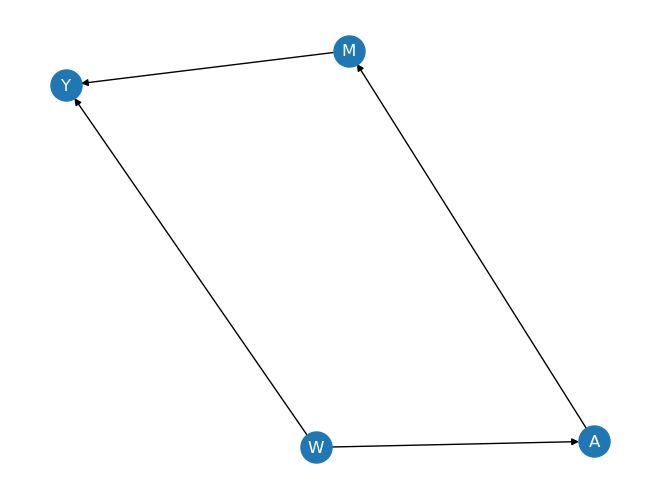

In [55]:
# DGP structure
graph = nx.DiGraph()

graph.add_edges_from(
    [
        ('W', 'A'),
        ('A', 'M'),
        ('M', 'Y'),
        ('W', 'Y'),
    ]
)

nx.draw(
    graph,
    with_labels=True,
    font_color='white',
    node_size=500,
)

In [56]:
# Confounder
W = stats.norm(0, 1).rvs(N_SAMPLES)

# Treatment
A = stats.norm(0, 1).rvs(N_SAMPLES) + 0.5*W

# Mediator
M = 2*A + stats.norm(0, 2).rvs(N_SAMPLES)

# Outcome
Y = -3*M -2*W + stats.norm(0, 1).rvs(N_SAMPLES)

# Ture Effect A -> Y = -6

In [57]:
# Initialize the model (with default base learners)
dml = LinearDML()

In [58]:
# All controls (correct specification: no mediator included)
X = W.reshape(-1, 1)

In [59]:
# Fit the model
dml.fit(
    T=A,
    X=X,
    Y=Y
)

In [60]:
# Predicted effect
dml.effect(X=X, T0=0, T1=1).mean()

np.float64(-5.982578992838315)

### Results Summary:

**Predicted effect**: -5.98 ✅

**True effect**: -6.00

## Case 1: Controlling for Mediators

In [36]:
# Confounder
W = stats.norm(0, 1).rvs(N_SAMPLES)

# Treatment
A = stats.norm(0, 1).rvs(N_SAMPLES) + 0.5*W

# Mediator
M = 2*A + stats.norm(0, 2).rvs(N_SAMPLES)

# Outcome
Y = -3*M -2*W + stats.norm(0, 1).rvs(N_SAMPLES)

# Ture Effect A -> Y = -6

In [37]:
# Initialize the model (with default base learners)
dml = LinearDML()

In [61]:
# All controls (‼️misspecification: mediator included)
X = np.stack([W, M]).T

In [62]:
# Fit the model
dml.fit(
    T=A,
    X=X,
    Y=Y
)

In [64]:
# Predicted effect
dml.effect(X=X, T0=0, T1=1).mean()

np.float64(-0.011980482861522899)

### Results Summary:

**Predicted effect**: -0.012 ❌

**True effect**: -6.000

## Case 2: Controlling for (Noisy) Colliders

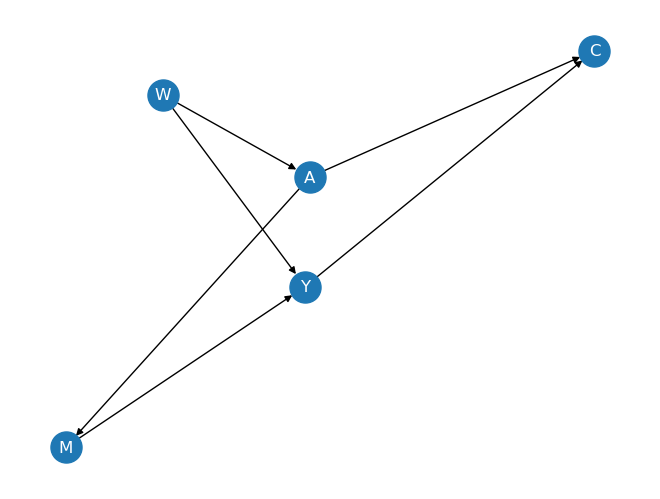

In [77]:
# DGP structure
graph = nx.DiGraph()

graph.add_edges_from(
    [
        ('W', 'A'),
        ('A', 'M'),
        ('M', 'Y'),
        ('W', 'Y'),
        ('A', 'C'),
        ('Y', 'C')
    ]
)

nx.draw(
    graph,
    with_labels=True,
    font_color='white',
    node_size=500,
)

In [93]:
# Confounder
W = stats.norm(0, 1).rvs(N_SAMPLES)

# Treatment
A = stats.norm(0, 1).rvs(N_SAMPLES) + 0.5*W

# Mediator
M = 2*A + stats.norm(0, 2).rvs(N_SAMPLES)

# Outcome
Y = -3*M -2*W + stats.norm(0, 1).rvs(N_SAMPLES)

# Collider
C = -1.3*A + 6*Y + stats.norm(0, 4).rvs(N_SAMPLES)

# Ture Effect A -> Y = -6

In [94]:
# Initialize the model (with default base learners)
dml = LinearDML()

In [95]:
# All controls (‼️misspecification: noisy collider included)
X = np.stack([W, C]).T

In [96]:
# Fit the model
dml.fit(
    T=A,
    X=X,
    Y=Y
)

In [97]:
# Predicted effect
dml.effect(X=X, T0=0, T1=1).mean()

np.float64(0.13880817312216617)

### Results Summary:

**Predicted effect**: 0.15 ❌

**True effect**: -6.00